# New York City Taxi Fare Prediction
## Team member：¶

*   Haoun Guo hg1483
*   Da Cai dc4069
*   Naisheng Zhang nz862





In [0]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

os.getcwd()
os.chdir('/content')
os.getcwd()
# help(pd.read_csv)

'/content'

In [0]:
TRAIN_PATH = 'drive/My Drive/train.csv'
TEST_PATH = 'drive/My Drive/test.csv'
DATASET_SIZE = 200000
# datatypes = {'key': 'str', 
#               'fare_amount': 'float32',
#               'pickup_datetime': 'str', 
#               'pickup_longitude': 'float32',
#               'pickup_latitude': 'float32',
#               'dropoff_longitude': 'float32',
#               'dropoff_latitude': 'float32',
#               'passenger_count': 'uint8'}
train = pd.read_csv(TRAIN_PATH, nrows=DATASET_SIZE)
test = pd.read_csv(TEST_PATH)
train.head()
# test=test.drop('key', axis=1)
test.head()
print('Old size: %d' % len(train))
train = train[train.fare_amount>=0]
print('New size: %d' % len(train))

Old size: 200000
New size: 199987


In [0]:
print('Old size: %d' % len(train))
train = train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train))

Old size: 199987
New size: 199986


In [0]:
train.describe(percentiles=[0.25,0.5,0.75,0.95])

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,199986.000000,199986.000000,199986.000000,199986.000000,199986.000000,199986.000000
mean,11.344032,-72.506021,39.922268,-72.518951,39.925729,1.682423
std,9.836736,11.608497,10.049296,10.723343,6.750746,1.306692
min,0.000000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992050,40.735006,-73.991296,40.734092,1.000000
50%,8.500000,-73.981743,40.752761,-73.980072,40.753225,1.000000
75%,12.500000,-73.967070,40.767126,-73.963509,40.768070,2.000000
95%,30.500000,-73.872123,40.787727,-73.875011,40.793872,5.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [0]:
print('Old size: %d' % len(train))
# print((train['dropoff_longitude'] ==train['pickup_longitude']))
def boundary(df):
    # Delimiter lats and lons to NY only
    df = df[(-74.5 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72.8)]
    df = df[(-74.5 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72.8)]
    df = df[(40.5 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 41.8)]
    df = df[(40.5<= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 41.8)]
    # Remove possible outliers
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 31)]
    df=df[df['passenger_count']<=5]
    # Remove inconsistent values
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df
train_boundary = boundary(train)
print('New size: %d' % len(train_boundary))
train_boundary.head()

Old size: 199986
New size: 180707


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
# test['pickup_datetime'] =  pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
# print(test['pickup_datetime'])

In [0]:
def spring(row):
    if (row['month'] >=4) and (row['month'] <7):
        return 1
    else:
        return 0  
def summer(row):
    if (row['month'] >=7) and (row['month'] <10):
        return 1
    else:
        return 0
def fall(row):
    if (row['month'] >=10) and (row['month'] <=12):
        return 1
    else:
        return 0  
def winter(row):
    if (row['month'] >=1) and (row['month'] <4):
        return 1
    else:
        return 0  
 
def weekend1(row):
    if row['weekday'] < 5:
        return 1
    else:
        return 0

def workday1(row):
    if row['weekday'] >= 5:
        return 1
    else:
        return 0
def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >20):
        return 1
    else:
        return 0
def night (row):
    if ((row['hour'] <= 20) and (row['hour'] > 16)):
        return 1
    else:
        return 0    
def day_time(row):
    if (row['hour'] <= 16) and (row['hour'] >6):
        return 1
    else:
        return 0


def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['key'], format='%Y-%m-%d %H:%M:%S')
   
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
   
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    df['spring']=df.apply (lambda x: spring(x), axis=1)
    df['summer']=df.apply (lambda x: summer(x), axis=1)
    df['fall']=df.apply (lambda x: fall(x), axis=1)
    df['winter']=df.apply (lambda x: winter(x), axis=1)
    df['workday'] = df.apply(lambda x: workday1(x),axis=1)
    df['weekend'] = df.apply(lambda x: weekend1(x), axis=1)
    
    
    df['night'] = df.apply (lambda x: night(x), axis=1)
    df['late_night'] = df.apply (lambda x: late_night(x), axis=1)
    df['day_time'] = df.apply (lambda x: day_time(x), axis=1)
    
    # Drop 'pickup_datetime' as we won't need it anymore
#     df = df.drop('pickup_datetime', axis=1)
    return df
#2009-2015

In [0]:
train_time = add_time_features(train_boundary)

train_time.head()
# test_time['year'].max()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,...,weekday,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21.000000100,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,...,0,1,0,0,0,0,1,1,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16.000000200,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,...,1,0,0,0,1,0,1,0,0,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00.000000490,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,...,3,0,1,0,0,0,1,0,1,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42.000000100,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,...,5,1,0,0,0,1,0,0,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00.000000135,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,...,1,0,0,0,1,0,1,0,0,1


In [0]:
# test = pd.read_csv(TEST_PATH)
test_time = add_time_features(test)
test_time.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,weekday,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24.000000200,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,...,1,0,0,0,1,0,1,0,0,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24.000000300,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,...,1,0,0,0,1,0,1,0,0,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44.000000200,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,...,5,0,0,1,0,1,0,0,0,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12.000000200,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,...,5,0,0,1,0,1,0,0,1,0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12.000000300,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,...,5,0,0,1,0,1,0,0,1,0


In [0]:
# test_time

In [0]:
train_time=train_time.drop(['day','hour','month','key','pickup_datetime','weekday'] , axis=1)
test_time=test_time.drop(['day','hour','month','key','pickup_datetime','weekday'] , axis=1)


In [0]:
test_time.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,0,0,0,1,0,1,0,0,1
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,0,0,0,1,0,1,0,0,1
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,0,0,1,0,1,0,0,0,1
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,0,0,1,0,1,0,0,1,0
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,0,0,1,0,1,0,0,1,0


In [0]:
# help(map)
import math
math.pi

3.141592653589793

In [0]:
# from math import radians, cos, sin, asin, sqrt
# def geodistance(lng1,lat1,lng2,lat2):
#     lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
#     dlon=lng2-lng1
#     dlat=lat2-lat1
#     a=np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2 
#     dis=2*np.arcsin(np.sqrt(a))*6371*1000
#     return dis
# a=np.array([1,2,3],[1,2,3],[4,5,6],[4,5,6])
import math
# from math import radians, cos, sin, asin, sqrt，pi
def geodistance(lon1,latt1,lon2,latt2):
    lng1=lon1*math.pi/180
    lat1=latt1*math.pi/180
    lng2=lon2*math.pi/180
    lat2=latt2*math.pi/180
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2 
    dis=2*np.arcsin(np.sqrt(a))*6371
    return dis
a=geodistance(-74.0063889,40.7141667,-73.7822222222,40.6441666667)
a

20.443095838269418

In [0]:
train_time.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,1,0,0,0,0,1,1,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,0,0,0,1,0,1,0,0,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,0,1,0,0,0,1,0,1,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,1,0,0,0,1,0,0,1,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,0,0,0,1,0,1,0,0,1


In [0]:
def distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
  
def add_distances_features(df):
    # Add distances from airpot and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
   
#     df['distance'] = distance(lon1,lat1,lon2,lat2)
    df['distance']=geodistance(lon1,lat1,lon2,lat2)

    
    df['downtown_pickup_distance'] = distance(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] =distance(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = distance(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] =distance(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = distance(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = distance(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] =distance(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = distance(lgr[1], lgr[0], lat2, lon2)
    return df

In [0]:
test_time.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,spring,summer,fall,winter,workday,weekend,night,late_night,day_time
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,0,0,0,1,0,1,0,0,1
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,0,0,0,1,0,1,0,0,1
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,0,0,1,0,1,0,0,0,1
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,0,0,1,0,1,0,0,1,0
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,0,0,1,0,1,0,0,1,0


In [0]:
# train_distance = add_distances_features(train_time)
test_distance = add_distances_features(test_time)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,spring,summer,fall,winter,...,day_time,distance,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,0,0,0,1,...,1,2.323260,0.082708,0.054628,0.310737,0.298877,0.275485,0.247405,0.109515,0.137595
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,0,0,0,1,...,1,2.425353,0.024743,0.032537,0.279857,0.311698,0.217521,0.225314,0.167479,0.159686
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,0,0,1,0,...,1,0.618628,0.060958,0.058707,0.307395,0.299404,0.253736,0.251485,0.131264,0.133515
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,0,0,1,0,...,0,1.961033,0.078869,0.053409,0.322578,0.315694,0.271647,0.246187,0.113353,0.138813
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,0,0,1,0,...,0,5.387301,0.115951,0.048084,0.329432,0.306603,0.308729,0.240862,0.115821,0.144138


In [0]:
train_distance = add_distances_features(train_time)

In [0]:
print(test_distance['distance'].min())
print(test_distance['distance'].max())
print(train_distance['distance'].min())
print(train_distance['distance'].max())

0.0
99.9960403451414
0.00013945256284962794
103.40546642859287


count    180707.000000
mean          2.819708
std           2.621193
min           0.000139
25%           1.251394
50%           2.083228
75%           3.582004
99%          11.207110
max         103.405466
Name: distance, dtype: float64

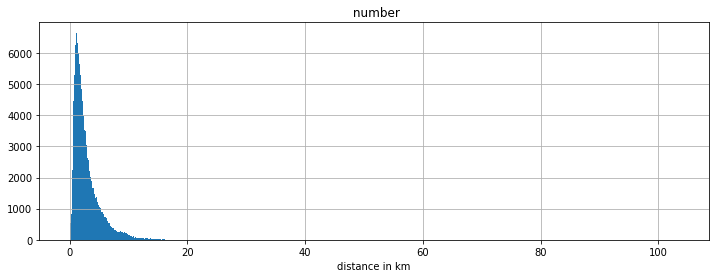

In [0]:
train_distance.distance.hist(bins=1000, figsize=(12,4))
plt.xlabel('distance in km')
plt.title(' number')
train_distance.distance.describe(percentiles=[0.25,0.5,0.75,0.99])

去掉实际距离小于10米的记录

In [0]:
print('Old size: %d' % len(train_distance))
train_distance1 = train_distance[train_distance.distance>=0.01]
print('New size: %d' % len(train_distance1))

Old size: 180707
New size: 180440


根据距离重新划分成0.1-1km,1km-4km,4km-15km,15km~

In [0]:
def distance_1km(row):
    if row['distance'] <1:
        return row['distance']
    else:
        return 1 
def distance_4km(row):
    if (row['distance'] >=1) and (row['distance'] <4):
        return row['distance']-1
    elif row['distance'] <1:
        return 0
    else:
        return 3
def distance_15km(row):
    if (row['distance'] >=4) and (row['distance'] <15):
        return row['distance']-4
    elif row['distance'] <4:
        return 0
    else:
        return 11  
def distance_long(row):
    if row['distance'] >=15:
        return row['distance']-15
    else:
        return 0  
 

def add_distance_filter_features(df):

    df['distance_1km']=df.apply (lambda x: distance_1km(x), axis=1)
    df['distance_4km']=df.apply (lambda x: distance_4km(x), axis=1)
    df['distance_15km']=df.apply (lambda x: distance_15km(x), axis=1)
    df['distance_long']=df.apply (lambda x: distance_long(x), axis=1)
 
    
    # Drop 'pickup_datetime' as we won't need it anymore
#     df = df.drop('pickup_datetime', axis=1)
    return df

In [0]:
train_distance2 = add_distance_filter_features(train_distance1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [0]:
test_distance2= add_distance_filter_features(test_distance)
print(train_distance2.shape,test_distance2.shape)
# print(train_distance2['distance'][20:40],train_distance2['distance_1km'][20:40],train_distance2['distance_4km'][20:40],train_distance2['distance_15km'][20:40],train_distance2['distance_long'][20:40])

(180440, 29) (9914, 28)


In [0]:
train_distance2.dtypes

fare_amount                  float64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
year                           int64
spring                         int64
summer                         int64
fall                           int64
winter                         int64
workday                        int64
weekend                        int64
night                          int64
late_night                     int64
day_time                       int64
distance                     float64
downtown_pickup_distance     float64
downtown_dropoff_distance    float64
jfk_pickup_distance          float64
jfk_dropoff_distance         float64
ewr_pickup_distance          float64
ewr_dropoff_distance         float64
lgr_pickup_distance          float64
lgr_dropoff_distance         float64
distance_1km                 float64
distance_4km                 float64
d

In [0]:
# 最后clean
dropped_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','distance']
train_clean = train_distance2.drop(dropped_columns, axis=1)
test_clean = test_distance2.drop(dropped_columns , axis=1)

# peek data
train_clean.head()

,fare_amount,passenger_count,year,spring,summer,fall,winter,workday,weekend,night,...,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance,distance_1km,distance_4km,distance_15km,distance_long
0,4.5,1,2009,1,0,0,0,0,1,1,...,0.139241,0.127499,0.362008,0.355668,0.074370,0.086112,1.0,0.030764,0.000000,0.0
1,16.9,1,2010,0,0,0,1,0,1,0,...,0.300962,0.334883,0.180255,0.287736,0.204745,0.121272,1.0,3.000000,4.450134,0.0
2,5.7,2,2011,0,1,0,0,0,1,0,...,0.317619,0.315415,0.263532,0.244320,0.121468,0.140680,1.0,0.389525,0.000000,0.0
3,7.7,1,2012,1,0,0,0,1,0,0,...,0.293884,0.323270,0.231013,0.251525,0.153987,0.133475,1.0,1.799270,0.000000,0.0
4,5.3,1,2010,0,0,0,1,0,1,0,...,0.309714,0.314028,0.284913,0.312107,0.100087,0.100417,1.0,0.999157,0.000000,0.0


In [0]:
train_df, validation_df = train_test_split(train_clean, test_size=0.10, random_state=1)
# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
validation_df = validation_df.drop(['fare_amount'], axis=1)

In [0]:
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)
validation_df_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_clean)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.001
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))
adam = optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_df_scaled, validation_labels), 
                    shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 162396 samples, validate on 18044 samples
Epoch 1/20
162396/162396 [==============================] - 10s 61us/step - loss: 62.7501 - mean_absolute_error: 7.0380 - val_loss: 17.0075 - val_mean_absolute_error: 3.3152
Epoch 2/20
162396/162396 [==============================] - 7s 40us/step - loss: 8.4069 - mean_absolute_error: 1.9551 - val_loss: 6.1724 - val_mean_absolute_error: 1.6817
Epoch 3/20
162396/162396 [==============================] - 6s 40us/step - loss: 6.3909 - mean_absolute_error: 1.6743 - val_loss: 6.2402 - val_mean_absolute_error: 1.6670
Epoch 4/20
162396/162396 [==============================] - 7s 41us/step - loss: 6.3163 - mean_absolute_error: 1.6676 - val_loss: 6.0388 - val_mean_absolute_error: 1.6506
Epoch 5/20
162396/162396 [==============================] - 7s 40us/step - loss: 6.2674 - mean_absolute_error: 1.6623 - val_loss: 5.9974 - val_mean_absolute_error: 1.6122
Epoch 6/20
162396/162396 [=================

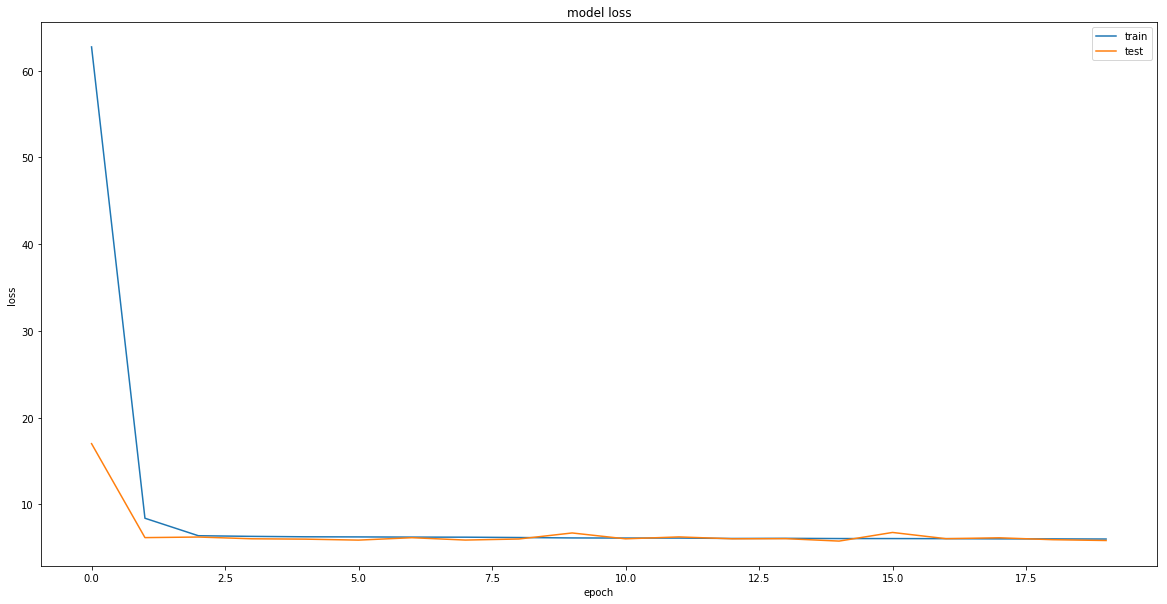

In [0]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
prediction = model.predict(train_df_scaled, batch_size=128, verbose=1)


162396/162396 [==============================] - 2s 13us/step
[5.967154]
9.7


In [0]:
prediction=prediction.flatten()
accuracy_list=np.abs(prediction-train_labels)/train_labels
accuracy=np.mean(accuracy_list<0.3)
print(accuracy_list[:20])
print(accuracy)
# print(np.sum(prediction-train_labels))

[0.20437946 0.37259767 0.27965625 0.14253885 0.44086838 0.09040529
 0.07400874 0.00370176 0.05543137 0.08524275 0.41248217 0.03247371
 0.14321613 0.30580224 0.24446742 0.15313823 0.0484346  0.28300454
 0.04636058 0.24530935]
0.8407411512598832
-24025.969251718525


In [0]:
accuracy_magnitude=np.sqrt(np.sum((prediction-train_labels)**2)/prediction.shape[0])
accuracy_magnitude

2.3900020018282717